In [1]:
# models_and_training.py
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GINConv, GATConv, global_mean_pool, global_max_pool
from torch_geometric.datasets import Planetoid, TUDataset
from torch_geometric.data import Data
import torch_geometric
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch_geometric.datasets import Planetoid

# Set random seed for reproducibility
torch_geometric.seed_everything(50)

class GCN(torch.nn.Module):
    def __init__(self, num_features, num_classes): 
        super().__init__()
        self.conv1 = GCNConv(num_features, 16)
        self.conv2 = GCNConv(16, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        # log softmax cause it's useful for multiclass classification 
        return F.log_softmax(x, dim=1)

# Enhanced GCN with Dropout and Leaky ReLU for Node Classification
class EnhancedGCN(torch.nn.Module):
    def __init__(self, num_features, num_classes): 
        super().__init__()
        self.conv1 = GCNConv(num_features, 16)
        self.conv2 = GCNConv(16, num_classes)
        self.dropout = torch.nn.Dropout(p = 0.5) # 50% dropout rate - this is typical starting point 
        self.leaky_relu = torch.nn.LeakyReLU(negative_slope=0.1) 

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        # tried new activation function
        x = self.leaky_relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        # log softmax cause it's useful for multiclass classification 
        return F.log_softmax(x, dim=1)
# Very simple, two GCN layers
class GCNGraphClassifier(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCNGraphClassifier, self).__init__()
        self.conv1 = GCNConv(num_features, 16)  # first GCN layer
        self.conv2 = GCNConv(16, 16)            # second GCN layer
        # fully connected layer for classification
        self.fc = torch.nn.Linear(16, num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # recognized the these nodes don't have features 
        if x is None:
            x = torch.ones((edge_index.max().item() + 1, 1)) 
            
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        x = global_mean_pool(x, batch)  # aggregate node features to graph level
        return F.log_softmax(self.fc(x), dim=1)  # log-softmax for multi-class classification

# changed to max pool 
# looks like the model for graph classification does well for multi-class data (like the ENZYME) but not so much for the binary one 
# let's try making the model deeper and increase size of hidden layers - didn't work (later we show increasing layers don't help)
# let's try making the model use global max instead - highered accuracy for ENZYME dataset 
# let's try cross entrophy loss - better results (especially for ENZYME)
# looking at the loss changes in IMDB, there is barely any changes, so let's trying lowering learning rate - increased accuracy by a LOT
class EnhancedGCNGraphClassifier(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(EnhancedGCNGraphClassifier, self).__init__()
        self.conv1 = GCNConv(num_features, 16)  # first GCN layer
        self.conv2 = GCNConv(16, 16)            # second GCN layer
        # fully connected layer for classification
        self.fc = torch.nn.Linear(16, num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # recognized the these nodes don't have features 
        if x is None:
            x = torch.ones((edge_index.max().item() + 1, 1)) 
            
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        x = global_max_pool(x, batch)  # aggregate node features to graph level
        return F.log_softmax(self.fc(x), dim=1)  # log-softmax for multi-class classification



# GIN Model for Node 
class GINModel(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GINModel, self).__init__()
        self.conv1 = GINConv(torch.nn.Linear(num_features, 64))
        self.conv2 = GINConv(torch.nn.Linear(64, num_classes))

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

# since the training accuracy looks a little high, let's normalize it somehow
# what about adding batchnorm? - didn't work
# what about learning rate? - didn't change much - let's try dropout
class EnhancedGINModel(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(EnhancedGINModel, self).__init__()
        self.conv1 = GINConv(torch.nn.Linear(num_features, 64))
        self.conv2 = GINConv(torch.nn.Linear(64, num_classes))
        self.dropout = torch.nn.Dropout(0.5) # added
        
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index).relu()
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x

# Simple GINGraphClassifier
class GINGraphClassifier(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GINGraphClassifier, self).__init__()
        self.conv1 = GINConv(torch.nn.Linear(num_features, 16))
        self.conv2 = GINConv(torch.nn.Linear(16, 16))
        self.fc = torch.nn.Linear(16, num_classes)
        self.pool = global_mean_pool

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        if x is None:
            x = torch.ones((edge_index.max().item() + 1, 1)) 

        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        x = self.pool(x, batch)
        x = self.fc(x)
        return x

#  add some dropout to help with regularization and increase epochs
# larger hidden layers
class EnhancedGINGraphClassifier(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(EnhancedGINGraphClassifier, self).__init__()
        self.conv1 = GINConv(torch.nn.Linear(num_features, 64))
        self.conv2 = GINConv(torch.nn.Linear(64, 64))
        self.fc = torch.nn.Linear(64, num_classes)
        self.dropout = torch.nn.Dropout(0.5)
        self.pool = global_mean_pool

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        if x is None:
            x = torch.ones((edge_index.max().item() + 1, 1)) 

        x = self.conv1(x, edge_index).relu()
        x = self.dropout(x)
        x = self.conv2(x, edge_index).relu()
        x = self.dropout(x)
        x = self.pool(x, batch)
        x = self.fc(x)
        return x

# Simple two layed GAT for node classification 
class GAT(torch.nn.Module):
    def __init__(self, num_features, num_classes, num_heads=1):
        super(GAT, self).__init__()
        self.conv1 = GATConv(num_features, 16, heads=num_heads)
        self.conv2 = GATConv(16 * num_heads, num_classes, heads=1, concat=False)
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# see multi-layers
class GAT_MultiLayer(torch.nn.Module):
    def __init__(self, num_features, num_classes, num_layers=3, hidden_dim=16, num_heads=1):
        super(GAT_MultiLayer, self).__init__()
        self.layers = torch.nn.ModuleList()
        self.layers.append(GATConv(num_features, hidden_dim, heads=num_heads))
        for _ in range(num_layers - 2):
            self.layers.append(GATConv(hidden_dim * num_heads, hidden_dim, heads=num_heads))
        self.layers.append(GATConv(hidden_dim * num_heads, num_classes, heads=1, concat=False))

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        for conv in self.layers[:-1]:
            x = F.relu(conv(x, edge_index))
        x = self.layers[-1](x, edge_index)
        return F.log_softmax(x, dim=1)
        
def train_and_evaluate_gat(dataset, device, layer_counts, hidden_dim=16, num_heads=1, lr=0.001, weight_decay=5e-4, epochs=100):
    data = dataset[0].to(device)
    results = []

    for layers in layer_counts:
        model = GAT_MultiLayer(num_features=data.x.size(1), num_classes=dataset.num_classes, num_layers=layers, hidden_dim=hidden_dim, num_heads=num_heads).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)  
        criterion = torch.nn.CrossEntropyLoss()
        
        # Training loop
        model.train()
        for epoch in range(epochs):
            optimizer.zero_grad()
            out = model(data)
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            loss.backward()
            optimizer.step()
        
        # Evaluation
        model.eval()
        pred = model(data).argmax(dim=1)
        train_correct = (pred[data.train_mask] == data.y[data.train_mask]).sum()
        train_acc = int(train_correct) / int(data.train_mask.sum())
        test_correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
        test_acc = int(test_correct) / int(data.test_mask.sum())
        
        print(f'Layers: {layers}, Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}')
        results.append((layers, test_acc))

    # Plotting the results
    layer_counts, accuracies = zip(*results)
    plt.plot(layer_counts, accuracies, marker='o')
    plt.xlabel("Number of Layers")
    plt.ylabel("Accuracy")
    plt.title("GAT Accuracy vs. Number of Layers")
    plt.show()

    return results
# results = train_and_evaluate_gat(dataset, device, layer_counts=[2, 3, 4, 5])


# SO let's do 4 layers:
# did some dropout experimenting to regularize the model
class EnhancedGAT(torch.nn.Module):
    def __init__(self, num_features, num_classes, num_heads=1):
        super(EnhancedGAT, self).__init__() 
        self.conv1 = GATConv(num_features, 16, heads=num_heads, concat=True)
        self.conv2 = GATConv(16 * num_heads, 16, heads=num_heads, concat=True)
        self.conv3 = GATConv(16 * num_heads, 16, heads=num_heads, concat=True)
        self.conv4 = GATConv(16 * num_heads, num_classes, heads=1, concat=False)  # Final layer with one head
        self.dropout = torch.nn.Dropout(0.4)
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # pass through each GAT layer with activation and dropout
        x = F.relu(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = F.relu(self.conv2(x, edge_index))
        x = self.dropout(x)
        x = F.relu(self.conv3(x, edge_index))
        x = self.dropout(x)
        x = self.conv4(x, edge_index)
        
        return F.log_softmax(x, dim=1) 

# first GAT graph classifier model
class GATGraphClassifier(torch.nn.Module):
    def __init__(self, num_features, num_classes, num_heads=8, hidden_dim=32):
        super(GATGraphClassifier, self).__init__()
        # two layer gat
        self.conv1 = GATConv(num_features, hidden_dim, heads=num_heads, concat=True)
        self.conv2 = GATConv(hidden_dim * num_heads, hidden_dim, heads=num_heads, concat=True)
        
        # pooling layer for the graph-level embedding
        self.pool = global_mean_pool
        
        # fully connected layer for classification
        self.fc = torch.nn.Linear(hidden_dim * num_heads, num_classes)
        # self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        if x is None:
            x = torch.ones((edge_index.max().item() + 1, 1)) 
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = self.pool(x, batch)
        x = self.fc(x)
        
        return F.log_softmax(x, dim=1)  # Log-softmax for multi-class classification


# better to do num_head = 8, hidden_dim = 32 for GAT graph classifier model

# Dataset Loading Functions
def load_planetoid_dataset(name='Cora', root='/tmp/Cora'):
    return Planetoid(root=root, name=name)

def load_tudataset(name='ENZYMES', root='data'):
    return TUDataset(root=root, name=name)

# Split dataset for graph classification
def split_dataset(dataset, test_size=0.2, seed=42):
    dataset = dataset.shuffle()
    train_indices, test_indices = train_test_split(range(len(dataset)), test_size=test_size, random_state=seed)
    train_data = [dataset[i] for i in train_indices]
    test_data = [dataset[i] for i in test_indices]
    return train_data, test_data

# Training function for node classification
def train_and_evaluate_node_classification(model, data, device, criterion=F.nll_loss, epochs=50, lr=0.01, weight_decay=5e-4):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    train_losses = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        print(f"Epoch {epoch+1}, Loss: {loss:.4f}")

    model.eval()
    pred = model(data).argmax(dim=1)
    train_correct = (pred[data.train_mask] == data.y[data.train_mask]).sum()
    train_acc = int(train_correct) / int(data.train_mask.sum())
    test_correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
    test_acc = int(test_correct) / int(data.test_mask.sum())
    print(f'Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}')

    return train_acc, test_acc, train_losses

# General training function for graph classification
def train_and_evaluate_graph_classification(model, train_data, test_data, device, criterion=F.nll_loss, epochs=50, lr=0.01, weight_decay=5e-4):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    train_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for data in train_data:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data)
            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        train_losses.append(total_loss)
        print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

    # Training accuracy
    train_correct = 0
    train_total = 0
    for data in train_data:
        data = data.to(device)
        pred = model(data).argmax(dim=1)
        train_correct += (pred == data.y).sum().item()
        train_total += data.y.size(0)
    train_acc = train_correct / train_total

    # Test accuracy
    test_correct = 0
    test_total = 0
    for data in test_data:
        data = data.to(device)
        pred = model(data).argmax(dim=1)
        test_correct += (pred == data.y).sum().item()
        test_total += data.y.size(0)
    test_acc = test_correct / test_total

    print(f'Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}')
    return train_acc, test_acc, train_losses

def train_and_evaluate(model, train_data, test_data, criterion = F.nll_loss, epochs=50, lr=0.01, weight_decay=5e-4):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    train_losses = []
    
    # Training loop
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for data in train_data:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data)
            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")
        train_losses.append(total_loss)
    model.eval()
    train_correct = 0
    train_total = 0
    for data in train_data:
        data = data.to(device)
        pred = model(data).argmax(dim=1)
        train_correct += (pred == data.y).sum().item()
        train_total += data.y.size(0)
    train_acc = train_correct / train_total

    # calculate test accuracy
    test_correct = 0
    test_total = 0
    for data in test_data:
        data = data.to(device)
        pred = model(data).argmax(dim=1)
        test_correct += (pred == data.y).sum().item()
        test_total += data.y.size(0)
    test_acc = test_correct / test_total

    print(f'Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}')
    return train_acc, test_acc, train_losses

# Plotting function for training losses
def plot_losses(train_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.legend()
    plt.show()


Epoch 1, Loss: 1.9437
Epoch 2, Loss: 1.8187
Epoch 3, Loss: 1.6736
Epoch 4, Loss: 1.5136
Epoch 5, Loss: 1.3553
Epoch 6, Loss: 1.2024
Epoch 7, Loss: 1.0560
Epoch 8, Loss: 0.9180
Epoch 9, Loss: 0.7900
Epoch 10, Loss: 0.6736
Epoch 11, Loss: 0.5699
Epoch 12, Loss: 0.4792
Epoch 13, Loss: 0.4011
Epoch 14, Loss: 0.3347
Epoch 15, Loss: 0.2788
Epoch 16, Loss: 0.2320
Epoch 17, Loss: 0.1931
Epoch 18, Loss: 0.1609
Epoch 19, Loss: 0.1343
Epoch 20, Loss: 0.1123
Epoch 21, Loss: 0.0942
Epoch 22, Loss: 0.0793
Epoch 23, Loss: 0.0671
Epoch 24, Loss: 0.0570
Epoch 25, Loss: 0.0486
Epoch 26, Loss: 0.0418
Epoch 27, Loss: 0.0361
Epoch 28, Loss: 0.0314
Epoch 29, Loss: 0.0274
Epoch 30, Loss: 0.0241
Epoch 31, Loss: 0.0214
Epoch 32, Loss: 0.0191
Epoch 33, Loss: 0.0171
Epoch 34, Loss: 0.0155
Epoch 35, Loss: 0.0141
Epoch 36, Loss: 0.0129
Epoch 37, Loss: 0.0118
Epoch 38, Loss: 0.0110
Epoch 39, Loss: 0.0102
Epoch 40, Loss: 0.0095
Epoch 41, Loss: 0.0089
Epoch 42, Loss: 0.0084
Epoch 43, Loss: 0.0080
Epoch 44, Loss: 0.00

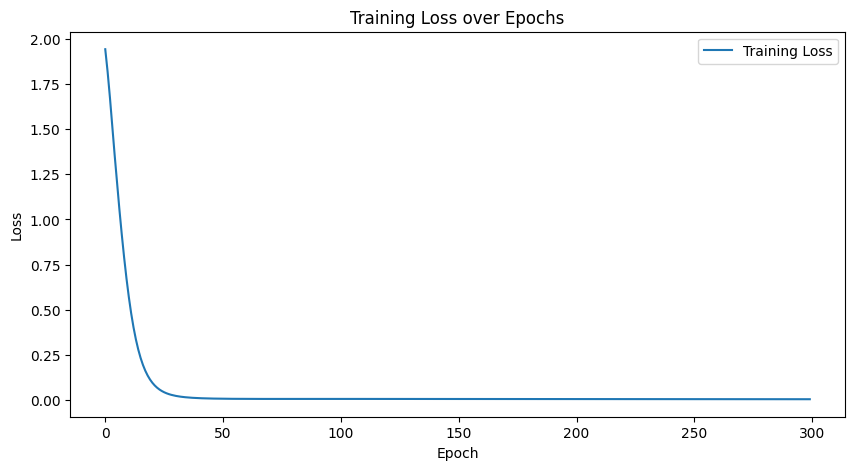

In [4]:
torch_geometric.seed_everything(50)
dataset = Planetoid(root='/tmp/Cora', name='Cora')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(dataset.num_features, dataset.num_classes).to(device)
data = dataset[0].to(device)
train_acc, test_acc, train_losses = train_and_evaluate_node_classification(model, data, device, F.nll_loss, 300, 0.01, 1e-4)
plot_losses(train_losses)

Epoch 1, Loss: 1.9480
Epoch 2, Loss: 1.8192
Epoch 3, Loss: 1.6828
Epoch 4, Loss: 1.5340
Epoch 5, Loss: 1.3657
Epoch 6, Loss: 1.2509
Epoch 7, Loss: 1.0839
Epoch 8, Loss: 0.9563
Epoch 9, Loss: 0.8738
Epoch 10, Loss: 0.7967
Epoch 11, Loss: 0.6679
Epoch 12, Loss: 0.6045
Epoch 13, Loss: 0.5148
Epoch 14, Loss: 0.4781
Epoch 15, Loss: 0.4105
Epoch 16, Loss: 0.3770
Epoch 17, Loss: 0.2963
Epoch 18, Loss: 0.3124
Epoch 19, Loss: 0.2267
Epoch 20, Loss: 0.2556
Epoch 21, Loss: 0.2173
Epoch 22, Loss: 0.2182
Epoch 23, Loss: 0.1431
Epoch 24, Loss: 0.1734
Epoch 25, Loss: 0.1103
Epoch 26, Loss: 0.1309
Epoch 27, Loss: 0.1095
Epoch 28, Loss: 0.1161
Epoch 29, Loss: 0.0928
Epoch 30, Loss: 0.1326
Epoch 31, Loss: 0.0741
Epoch 32, Loss: 0.0760
Epoch 33, Loss: 0.0733
Epoch 34, Loss: 0.0647
Epoch 35, Loss: 0.0466
Epoch 36, Loss: 0.0494
Epoch 37, Loss: 0.0504
Epoch 38, Loss: 0.0564
Epoch 39, Loss: 0.0584
Epoch 40, Loss: 0.0519
Epoch 41, Loss: 0.0680
Epoch 42, Loss: 0.0621
Epoch 43, Loss: 0.0579
Epoch 44, Loss: 0.03

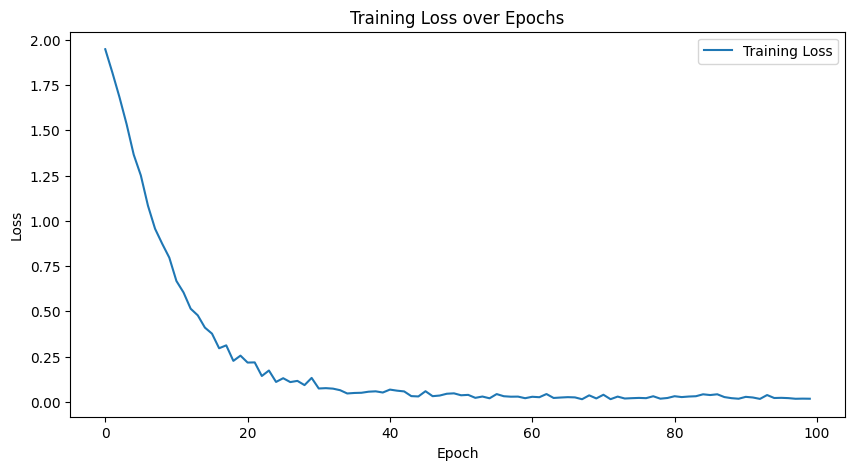

In [5]:
torch_geometric.seed_everything(50)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EnhancedGCN(dataset.num_features, dataset.num_classes).to(device)
data = dataset[0].to(device)
train_acc, test_acc, train_losses = train_and_evaluate_node_classification(model, data, device, F.nll_loss, 100, 0.01, 1e-4)
plot_losses(train_losses)

Epoch 1, Loss: 871.0424
Epoch 2, Loss: 863.7206
Epoch 3, Loss: 861.0966
Epoch 4, Loss: 858.8436
Epoch 5, Loss: 857.6206
Epoch 6, Loss: 856.9530
Epoch 7, Loss: 856.3019
Epoch 8, Loss: 855.5148
Epoch 9, Loss: 853.9157
Epoch 10, Loss: 852.8642
Epoch 11, Loss: 852.2210
Epoch 12, Loss: 851.1830
Epoch 13, Loss: 851.0254
Epoch 14, Loss: 851.0519
Epoch 15, Loss: 850.5222
Epoch 16, Loss: 850.1577
Epoch 17, Loss: 850.0885
Epoch 18, Loss: 850.1110
Epoch 19, Loss: 849.6877
Epoch 20, Loss: 849.2732
Epoch 21, Loss: 849.4159
Epoch 22, Loss: 848.9899
Epoch 23, Loss: 848.1216
Epoch 24, Loss: 848.2913
Epoch 25, Loss: 847.0712
Epoch 26, Loss: 846.6384
Epoch 27, Loss: 846.4748
Epoch 28, Loss: 845.0461
Epoch 29, Loss: 844.7712
Epoch 30, Loss: 843.6544
Epoch 31, Loss: 843.0081
Epoch 32, Loss: 842.3587
Epoch 33, Loss: 841.9114
Epoch 34, Loss: 841.1783
Epoch 35, Loss: 840.9272
Epoch 36, Loss: 840.9573
Epoch 37, Loss: 840.7716
Epoch 38, Loss: 840.3116
Epoch 39, Loss: 841.1660
Epoch 40, Loss: 840.1852
Epoch 41,

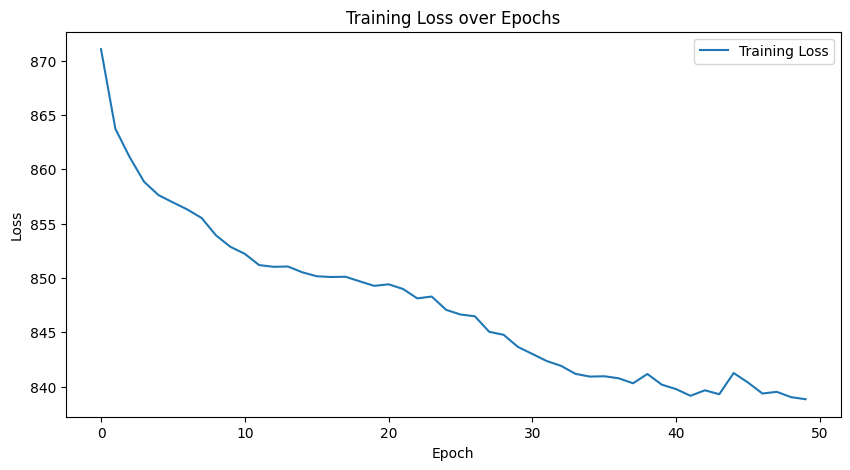

Epoch 1, Loss: 557.2567
Epoch 2, Loss: 556.7813
Epoch 3, Loss: 556.4831
Epoch 4, Loss: 556.8091
Epoch 5, Loss: 556.6813
Epoch 6, Loss: 556.6088
Epoch 7, Loss: 556.9639
Epoch 8, Loss: 556.9544
Epoch 9, Loss: 557.1251
Epoch 10, Loss: 556.5926
Epoch 11, Loss: 557.9954
Epoch 12, Loss: 556.7080
Epoch 13, Loss: 557.3050
Epoch 14, Loss: 556.5889
Epoch 15, Loss: 556.5337
Epoch 16, Loss: 557.2942
Epoch 17, Loss: 557.7845
Epoch 18, Loss: 556.4847
Epoch 19, Loss: 556.5305
Epoch 20, Loss: 558.8902
Epoch 21, Loss: 554.7828
Epoch 22, Loss: 556.4483
Epoch 23, Loss: 556.5581
Epoch 24, Loss: 556.4761
Epoch 25, Loss: 557.4143
Epoch 26, Loss: 556.5803
Epoch 27, Loss: 556.4673
Epoch 28, Loss: 556.9983
Epoch 29, Loss: 556.2526
Epoch 30, Loss: 556.8054
Epoch 31, Loss: 556.9838
Epoch 32, Loss: 556.5189
Epoch 33, Loss: 556.5079
Epoch 34, Loss: 556.9497
Epoch 35, Loss: 558.2833
Epoch 36, Loss: 556.4200
Epoch 37, Loss: 556.7521
Epoch 38, Loss: 558.0584
Epoch 39, Loss: 556.3791
Epoch 40, Loss: 556.7773
Epoch 41,

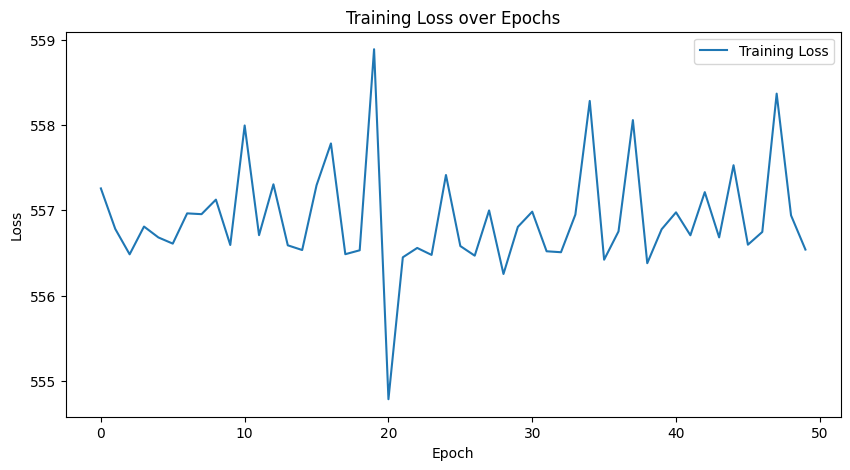

In [11]:
torch_geometric.seed_everything(50)

enzymes_dataset = TUDataset(root='data/ENZYMES', name='ENZYMES')
imdb_dataset = TUDataset(root='data/IMDB-BINARY', name='IMDB-BINARY')

train_data_enz, test_data_enz = split_dataset(enzymes_dataset)
train_data_imdb, test_data_imdb = split_dataset(imdb_dataset)

model_enz = GCNGraphClassifier(num_features=enzymes_dataset.num_node_features, num_classes=enzymes_dataset.num_classes)
train_acc, test_acc, train_losses = train_and_evaluate(model_enz, train_data_enz, test_data_enz)
plot_losses(train_losses)

model_imdb = GCNGraphClassifier(num_features=1, num_classes=2)  
train_acc, test_acc, train_losses = train_and_evaluate(model_imdb, train_data_imdb, test_data_imdb)
plot_losses(train_losses)

Epoch 1, Loss: 863.5239
Epoch 2, Loss: 857.0397
Epoch 3, Loss: 852.8895
Epoch 4, Loss: 848.4847
Epoch 5, Loss: 844.1922
Epoch 6, Loss: 840.6013
Epoch 7, Loss: 837.7982
Epoch 8, Loss: 835.6644
Epoch 9, Loss: 833.8739
Epoch 10, Loss: 832.3623
Epoch 11, Loss: 831.0151
Epoch 12, Loss: 829.7939
Epoch 13, Loss: 828.6648
Epoch 14, Loss: 827.5026
Epoch 15, Loss: 826.4534
Epoch 16, Loss: 825.4874
Epoch 17, Loss: 824.4978
Epoch 18, Loss: 823.5111
Epoch 19, Loss: 822.6534
Epoch 20, Loss: 821.8165
Epoch 21, Loss: 820.9758
Epoch 22, Loss: 820.1827
Epoch 23, Loss: 819.3347
Epoch 24, Loss: 818.4848
Epoch 25, Loss: 817.6659
Epoch 26, Loss: 816.8299
Epoch 27, Loss: 816.0036
Epoch 28, Loss: 815.3279
Epoch 29, Loss: 814.6691
Epoch 30, Loss: 813.9936
Epoch 31, Loss: 813.3198
Epoch 32, Loss: 812.7316
Epoch 33, Loss: 812.1482
Epoch 34, Loss: 811.5313
Epoch 35, Loss: 810.9738
Epoch 36, Loss: 810.3937
Epoch 37, Loss: 809.7248
Epoch 38, Loss: 809.1495
Epoch 39, Loss: 808.5824
Epoch 40, Loss: 807.9795
Epoch 41,

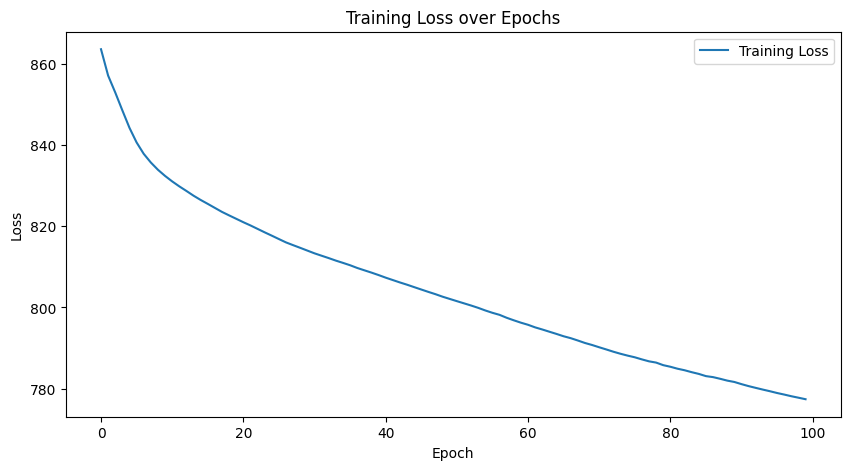

Epoch 1, Loss: 552.4812
Epoch 2, Loss: 552.2525
Epoch 3, Loss: 551.8833
Epoch 4, Loss: 551.6372
Epoch 5, Loss: 551.4714
Epoch 6, Loss: 551.3102
Epoch 7, Loss: 551.1835
Epoch 8, Loss: 551.0912
Epoch 9, Loss: 551.0003
Epoch 10, Loss: 550.8965
Epoch 11, Loss: 550.8280
Epoch 12, Loss: 550.7279
Epoch 13, Loss: 550.6284
Epoch 14, Loss: 550.5474
Epoch 15, Loss: 550.4612
Epoch 16, Loss: 550.3899
Epoch 17, Loss: 550.3348
Epoch 18, Loss: 550.2453
Epoch 19, Loss: 550.1930
Epoch 20, Loss: 550.1183
Epoch 21, Loss: 550.0576
Epoch 22, Loss: 550.0198
Epoch 23, Loss: 549.9520
Epoch 24, Loss: 549.8760
Epoch 25, Loss: 549.8464
Epoch 26, Loss: 549.7951
Epoch 27, Loss: 549.7533
Epoch 28, Loss: 549.7045
Epoch 29, Loss: 549.6535
Epoch 30, Loss: 549.6412
Epoch 31, Loss: 549.5898
Epoch 32, Loss: 549.5596
Epoch 33, Loss: 549.5359
Epoch 34, Loss: 549.4946
Epoch 35, Loss: 549.4933
Epoch 36, Loss: 549.4436
Epoch 37, Loss: 549.4215
Epoch 38, Loss: 549.4226
Epoch 39, Loss: 549.4273
Epoch 40, Loss: 549.3689
Epoch 41,

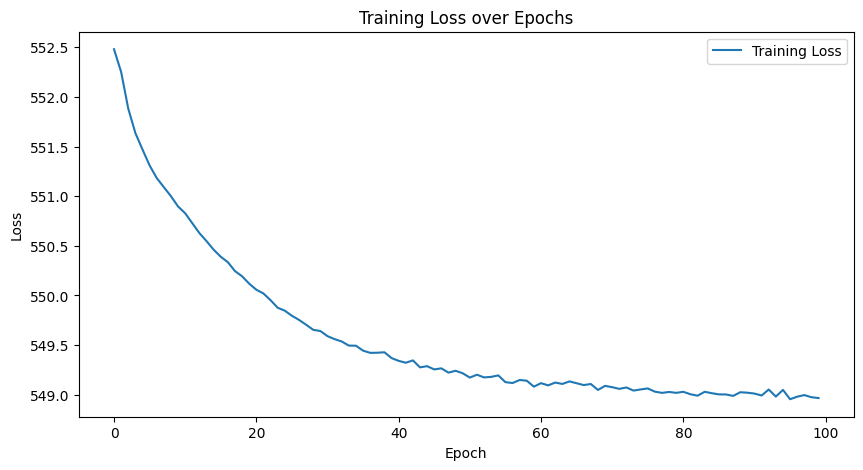

In [18]:
torch_geometric.seed_everything(50)
model_enz = EnhancedGCNGraphClassifier(num_features=enzymes_dataset.num_node_features, num_classes=enzymes_dataset.num_classes)
train_acc, test_acc, train_losses = train_and_evaluate(model_enz, train_data_enz, test_data_enz, criterion = torch.nn.CrossEntropyLoss(), epochs=100, lr=0.001, weight_decay=5e-4)
plot_losses(train_losses)

model_imdb = EnhancedGCNGraphClassifier(num_features=1, num_classes=2)  
train_acc, test_acc, train_losses = train_and_evaluate(model_imdb, train_data_imdb, test_data_imdb, criterion = torch.nn.CrossEntropyLoss(), epochs=100, lr=0.001, weight_decay=5e-4)
plot_losses(train_losses)

Epoch 1, Loss: 2.0735
Epoch 2, Loss: 3.4868
Epoch 3, Loss: 1.6775
Epoch 4, Loss: 1.7767
Epoch 5, Loss: 0.7402
Epoch 6, Loss: 0.5249
Epoch 7, Loss: 0.4282
Epoch 8, Loss: 0.4271
Epoch 9, Loss: 0.2073
Epoch 10, Loss: 0.2293
Epoch 11, Loss: 0.2431
Epoch 12, Loss: 0.2021
Epoch 13, Loss: 0.1321
Epoch 14, Loss: 0.0787
Epoch 15, Loss: 0.0695
Epoch 16, Loss: 0.0610
Epoch 17, Loss: 0.0505
Epoch 18, Loss: 0.0424
Epoch 19, Loss: 0.0359
Epoch 20, Loss: 0.0302
Epoch 21, Loss: 0.0256
Epoch 22, Loss: 0.0217
Epoch 23, Loss: 0.0185
Epoch 24, Loss: 0.0157
Epoch 25, Loss: 0.0132
Epoch 26, Loss: 0.0112
Epoch 27, Loss: 0.0094
Epoch 28, Loss: 0.0079
Epoch 29, Loss: 0.0067
Epoch 30, Loss: 0.0058
Epoch 31, Loss: 0.0050
Epoch 32, Loss: 0.0043
Epoch 33, Loss: 0.0038
Epoch 34, Loss: 0.0034
Epoch 35, Loss: 0.0030
Epoch 36, Loss: 0.0027
Epoch 37, Loss: 0.0024
Epoch 38, Loss: 0.0022
Epoch 39, Loss: 0.0020
Epoch 40, Loss: 0.0018
Epoch 41, Loss: 0.0017
Epoch 42, Loss: 0.0015
Epoch 43, Loss: 0.0014
Epoch 44, Loss: 0.00

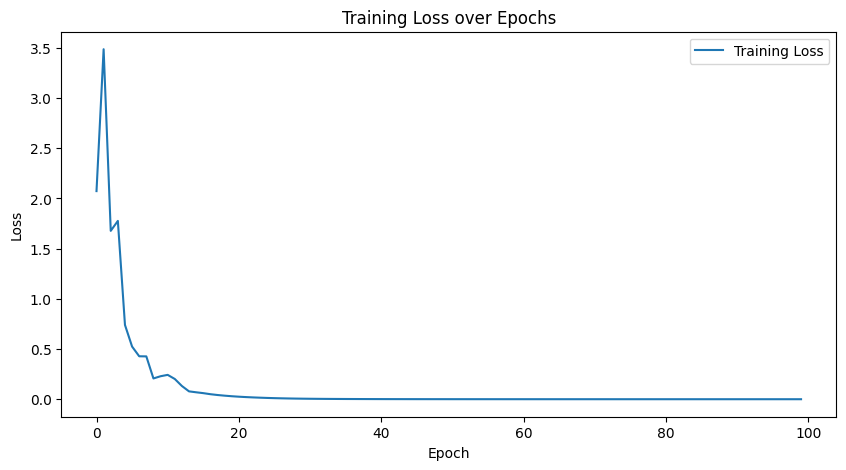

In [40]:
torch_geometric.seed_everything(50)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = dataset[0].to(device)
model = GINModel(dataset.num_node_features, dataset.num_classes)
train_acc, test_acc, train_losses = train_and_evaluate_node_classification(model, data, device, torch.nn.CrossEntropyLoss(), 100, 0.01, 1e-4)
plot_losses(train_losses)

Epoch 1, Loss: 2.0733
Epoch 2, Loss: 4.1096
Epoch 3, Loss: 1.7034
Epoch 4, Loss: 0.8391
Epoch 5, Loss: 0.6620
Epoch 6, Loss: 0.8764
Epoch 7, Loss: 0.7102
Epoch 8, Loss: 0.4947
Epoch 9, Loss: 0.4702
Epoch 10, Loss: 0.2996
Epoch 11, Loss: 0.4155
Epoch 12, Loss: 0.3182
Epoch 13, Loss: 0.2654
Epoch 14, Loss: 1.1418
Epoch 15, Loss: 0.1384
Epoch 16, Loss: 0.1499
Epoch 17, Loss: 0.1826
Epoch 18, Loss: 0.1133
Epoch 19, Loss: 0.1497
Epoch 20, Loss: 0.1531
Epoch 21, Loss: 0.1858
Epoch 22, Loss: 0.0709
Epoch 23, Loss: 0.1051
Epoch 24, Loss: 0.1385
Epoch 25, Loss: 0.1215
Epoch 26, Loss: 0.1441
Epoch 27, Loss: 0.0747
Epoch 28, Loss: 1.3331
Epoch 29, Loss: 0.1632
Epoch 30, Loss: 0.0636
Epoch 31, Loss: 0.1013
Epoch 32, Loss: 0.1235
Epoch 33, Loss: 0.2516
Epoch 34, Loss: 0.0897
Epoch 35, Loss: 0.1010
Epoch 36, Loss: 0.2180
Epoch 37, Loss: 0.0456
Epoch 38, Loss: 0.0969
Epoch 39, Loss: 0.1141
Epoch 40, Loss: 0.0964
Epoch 41, Loss: 0.0341
Epoch 42, Loss: 0.1078
Epoch 43, Loss: 0.0265
Epoch 44, Loss: 0.03

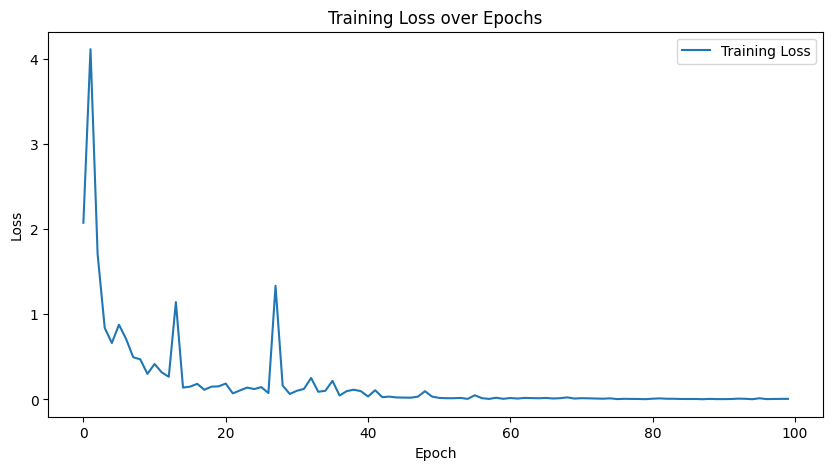

In [41]:
torch_geometric.seed_everything(50)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = dataset[0].to(device)
model = EnhancedGINModel(dataset.num_node_features, dataset.num_classes)
train_acc, test_acc, train_losses = train_and_evaluate_node_classification(model, data, device, torch.nn.CrossEntropyLoss(), 100, 0.01, 1e-4)
plot_losses(train_losses)

Epoch 1, Loss: 894.7634
Epoch 2, Loss: 851.6001
Epoch 3, Loss: 843.9711
Epoch 4, Loss: 838.7966
Epoch 5, Loss: 833.9464
Epoch 6, Loss: 830.0768
Epoch 7, Loss: 826.4851
Epoch 8, Loss: 824.2566
Epoch 9, Loss: 821.7120
Epoch 10, Loss: 819.0307
Epoch 11, Loss: 816.7043
Epoch 12, Loss: 816.4739
Epoch 13, Loss: 813.8536
Epoch 14, Loss: 811.7316
Epoch 15, Loss: 810.4991
Epoch 16, Loss: 809.0118
Epoch 17, Loss: 807.9496
Epoch 18, Loss: 806.5930
Epoch 19, Loss: 805.7118
Epoch 20, Loss: 804.2808
Epoch 21, Loss: 803.7448
Epoch 22, Loss: 802.5622
Epoch 23, Loss: 801.8713
Epoch 24, Loss: 800.9831
Epoch 25, Loss: 800.1523
Epoch 26, Loss: 799.5101
Epoch 27, Loss: 798.4322
Epoch 28, Loss: 798.0164
Epoch 29, Loss: 797.6088
Epoch 30, Loss: 797.0258
Epoch 31, Loss: 796.4879
Epoch 32, Loss: 796.1955
Epoch 33, Loss: 795.2924
Epoch 34, Loss: 795.0374
Epoch 35, Loss: 793.8969
Epoch 36, Loss: 794.1529
Epoch 37, Loss: 793.2207
Epoch 38, Loss: 792.8705
Epoch 39, Loss: 792.2096
Epoch 40, Loss: 792.2485
Epoch 41,

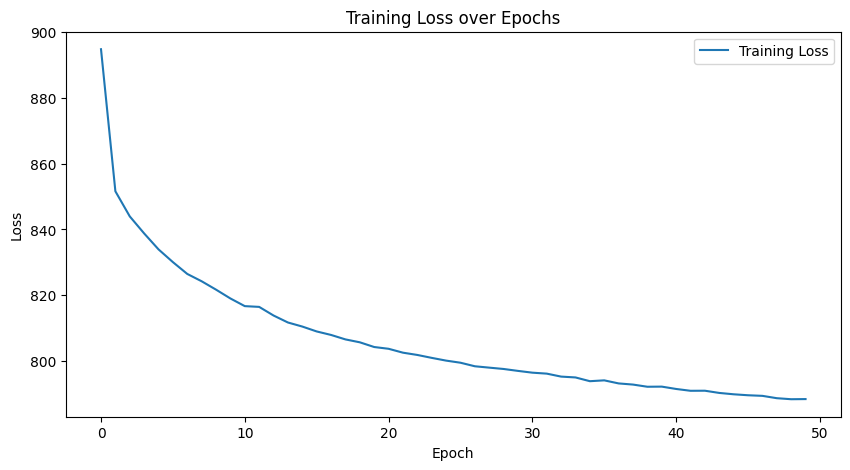

Epoch 1, Loss: 853.8910
Epoch 2, Loss: 785.0269
Epoch 3, Loss: 738.2410
Epoch 4, Loss: 697.9860
Epoch 5, Loss: 666.5509
Epoch 6, Loss: 640.0046
Epoch 7, Loss: 616.7241
Epoch 8, Loss: 597.1633
Epoch 9, Loss: 583.7014
Epoch 10, Loss: 568.7947
Epoch 11, Loss: 561.2661
Epoch 12, Loss: 543.0982
Epoch 13, Loss: 537.7494
Epoch 14, Loss: 533.6923
Epoch 15, Loss: 530.2071
Epoch 16, Loss: 526.5640
Epoch 17, Loss: 526.3030
Epoch 18, Loss: 520.6104
Epoch 19, Loss: 512.8793
Epoch 20, Loss: 508.2151
Epoch 21, Loss: 507.0305
Epoch 22, Loss: 502.9790
Epoch 23, Loss: 498.7979
Epoch 24, Loss: 495.2195
Epoch 25, Loss: 491.6779
Epoch 26, Loss: 488.8192
Epoch 27, Loss: 486.0648
Epoch 28, Loss: 483.7022
Epoch 29, Loss: 483.8806
Epoch 30, Loss: 483.8989
Epoch 31, Loss: 484.5353
Epoch 32, Loss: 483.3515
Epoch 33, Loss: 481.2525
Epoch 34, Loss: 481.8798
Epoch 35, Loss: 479.9940
Epoch 36, Loss: 480.5239
Epoch 37, Loss: 479.9132
Epoch 38, Loss: 478.2204
Epoch 39, Loss: 478.7021
Epoch 40, Loss: 475.8688
Epoch 41,

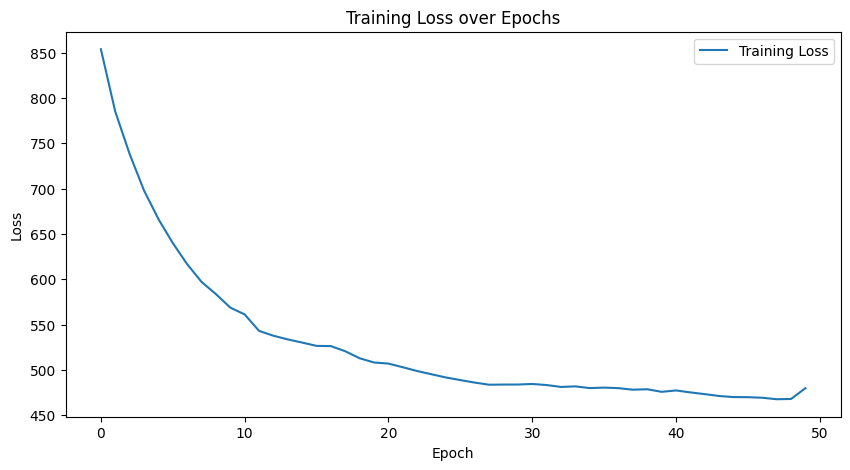

In [2]:
torch_geometric.seed_everything(50)

enzymes_dataset = TUDataset(root='data/ENZYMES', name='ENZYMES')
imdb_dataset = TUDataset(root='data/IMDB-BINARY', name='IMDB-BINARY')

train_data_enz, test_data_enz = split_dataset(enzymes_dataset)
train_data_imdb, test_data_imdb = split_dataset(imdb_dataset)
model_enz = GINGraphClassifier(num_features=enzymes_dataset.num_node_features, num_classes=enzymes_dataset.num_classes)
train_acc, test_acc, train_losses = train_and_evaluate(model_enz, train_data_enz, test_data_enz, criterion = torch.nn.CrossEntropyLoss(), epochs=50, lr=0.001, weight_decay=5e-4)
plot_losses(train_losses)

model_imdb = GINGraphClassifier(num_features=1, num_classes=2)  
train_acc, test_acc, train_losses = train_and_evaluate(model_imdb, train_data_imdb, test_data_imdb, criterion = torch.nn.CrossEntropyLoss(), epochs=50, lr=0.001, weight_decay=5e-4)
plot_losses(train_losses)

Epoch 1, Loss: 913.5842
Epoch 2, Loss: 862.2034
Epoch 3, Loss: 844.2488
Epoch 4, Loss: 844.4900
Epoch 5, Loss: 835.5934
Epoch 6, Loss: 834.3577
Epoch 7, Loss: 833.7334
Epoch 8, Loss: 831.1037
Epoch 9, Loss: 829.3706
Epoch 10, Loss: 822.6833
Epoch 11, Loss: 820.9910
Epoch 12, Loss: 812.0673
Epoch 13, Loss: 813.0431
Epoch 14, Loss: 815.1594
Epoch 15, Loss: 808.2685
Epoch 16, Loss: 812.7264
Epoch 17, Loss: 818.1040
Epoch 18, Loss: 809.9688
Epoch 19, Loss: 815.8590
Epoch 20, Loss: 824.0758
Epoch 21, Loss: 805.7295
Epoch 22, Loss: 808.6630
Epoch 23, Loss: 812.7055
Epoch 24, Loss: 807.7217
Epoch 25, Loss: 802.0673
Epoch 26, Loss: 806.4055
Epoch 27, Loss: 809.0737
Epoch 28, Loss: 800.8559
Epoch 29, Loss: 799.3930
Epoch 30, Loss: 812.1443
Epoch 31, Loss: 803.8654
Epoch 32, Loss: 804.4119
Epoch 33, Loss: 803.9100
Epoch 34, Loss: 804.8871
Epoch 35, Loss: 804.1747
Epoch 36, Loss: 802.1861
Epoch 37, Loss: 802.1816
Epoch 38, Loss: 797.6363
Epoch 39, Loss: 790.4537
Epoch 40, Loss: 798.1677
Epoch 41,

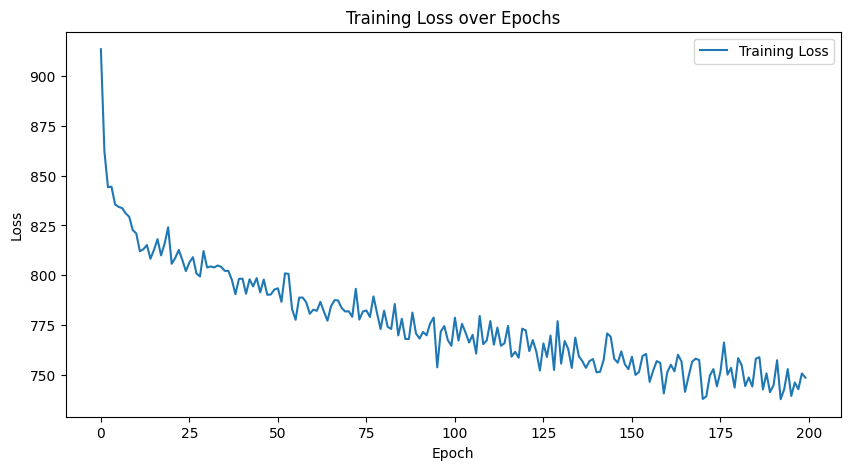

Epoch 1, Loss: 1879.0971
Epoch 2, Loss: 645.1541
Epoch 3, Loss: 570.3527
Epoch 4, Loss: 566.8103
Epoch 5, Loss: 591.8209
Epoch 6, Loss: 567.0934
Epoch 7, Loss: 555.4749
Epoch 8, Loss: 556.4353
Epoch 9, Loss: 561.1635
Epoch 10, Loss: 566.7685
Epoch 11, Loss: 554.7996
Epoch 12, Loss: 559.2432
Epoch 13, Loss: 568.2920
Epoch 14, Loss: 569.4816
Epoch 15, Loss: 554.8909
Epoch 16, Loss: 556.1540
Epoch 17, Loss: 555.4061
Epoch 18, Loss: 555.1952
Epoch 19, Loss: 577.3429
Epoch 20, Loss: 555.6676
Epoch 21, Loss: 555.7331
Epoch 22, Loss: 557.8013
Epoch 23, Loss: 571.0785
Epoch 24, Loss: 554.8217
Epoch 25, Loss: 554.7320
Epoch 26, Loss: 557.2536
Epoch 27, Loss: 560.8176
Epoch 28, Loss: 560.0361
Epoch 29, Loss: 556.7741
Epoch 30, Loss: 555.7750
Epoch 31, Loss: 555.2189
Epoch 32, Loss: 563.9611
Epoch 33, Loss: 558.1741
Epoch 34, Loss: 554.9180
Epoch 35, Loss: 555.3748
Epoch 36, Loss: 558.1941
Epoch 37, Loss: 600.2142
Epoch 38, Loss: 558.4316
Epoch 39, Loss: 556.7236
Epoch 40, Loss: 556.8027
Epoch 41

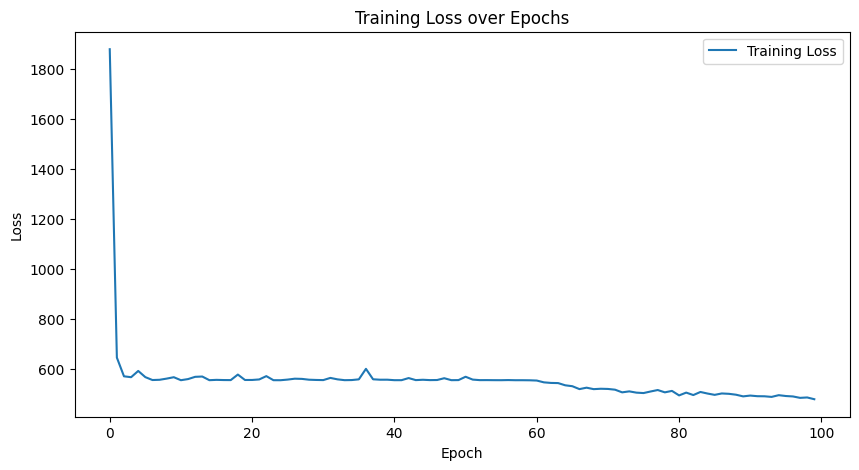

In [48]:
torch_geometric.seed_everything(50)
# maybe more epochs too 
model_enz = EnhancedGINGraphClassifier(num_features=enzymes_dataset.num_node_features, num_classes=enzymes_dataset.num_classes)
train_acc, test_acc, train_losses = train_and_evaluate(model_enz, train_data_enz, test_data_enz, criterion = torch.nn.CrossEntropyLoss(), epochs=200, lr=0.001, weight_decay=5e-4)
plot_losses(train_losses)
model_imdb = EnhancedGINGraphClassifier(num_features=1, num_classes=2)  
train_acc, test_acc, train_losses = train_and_evaluate(model_imdb, train_data_imdb, test_data_imdb, criterion = torch.nn.CrossEntropyLoss(), epochs=100, lr=0.001, weight_decay=5e-4)
plot_losses(train_losses)

Epoch 1, Loss: 1.9431
Epoch 2, Loss: 1.8135
Epoch 3, Loss: 1.6705
Epoch 4, Loss: 1.5121
Epoch 5, Loss: 1.3485
Epoch 6, Loss: 1.1837
Epoch 7, Loss: 1.0196
Epoch 8, Loss: 0.8588
Epoch 9, Loss: 0.7085
Epoch 10, Loss: 0.5743
Epoch 11, Loss: 0.4585
Epoch 12, Loss: 0.3599
Epoch 13, Loss: 0.2771
Epoch 14, Loss: 0.2099
Epoch 15, Loss: 0.1569
Epoch 16, Loss: 0.1161
Epoch 17, Loss: 0.0858
Epoch 18, Loss: 0.0636
Epoch 19, Loss: 0.0476
Epoch 20, Loss: 0.0360
Epoch 21, Loss: 0.0276
Epoch 22, Loss: 0.0214
Epoch 23, Loss: 0.0167
Epoch 24, Loss: 0.0133
Epoch 25, Loss: 0.0108
Epoch 26, Loss: 0.0089
Epoch 27, Loss: 0.0075
Epoch 28, Loss: 0.0063
Epoch 29, Loss: 0.0054
Epoch 30, Loss: 0.0047
Epoch 31, Loss: 0.0041
Epoch 32, Loss: 0.0036
Epoch 33, Loss: 0.0032
Epoch 34, Loss: 0.0028
Epoch 35, Loss: 0.0026
Epoch 36, Loss: 0.0023
Epoch 37, Loss: 0.0021
Epoch 38, Loss: 0.0019
Epoch 39, Loss: 0.0018
Epoch 40, Loss: 0.0016
Epoch 41, Loss: 0.0015
Epoch 42, Loss: 0.0014
Epoch 43, Loss: 0.0013
Epoch 44, Loss: 0.00

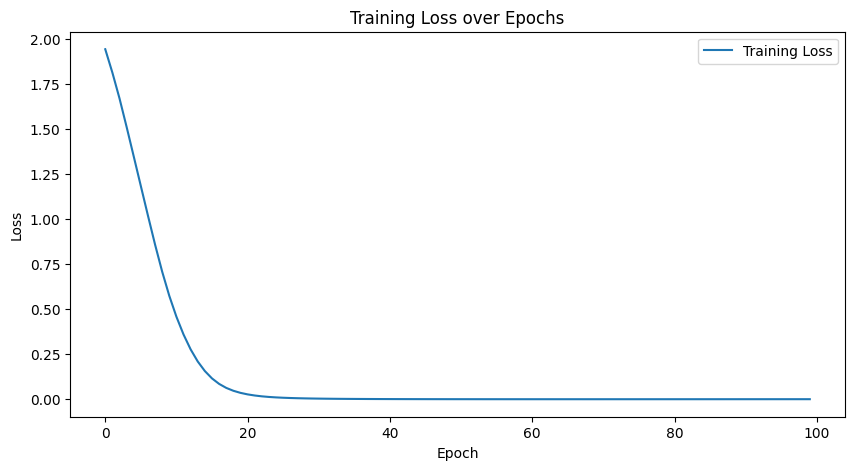

In [44]:
torch_geometric.seed_everything(50)
model = GAT(dataset.num_node_features, dataset.num_classes)
train_acc, test_acc, train_losses = train_and_evaluate_node_classification(model, data, device, torch.nn.CrossEntropyLoss(), 100, 0.01, 1e-4)
plot_losses(train_losses)

Layers: 2, Train Accuracy: 1.0000, Test Accuracy: 0.7620
Layers: 3, Train Accuracy: 0.9929, Test Accuracy: 0.7400
Layers: 4, Train Accuracy: 1.0000, Test Accuracy: 0.7730
Layers: 5, Train Accuracy: 0.9929, Test Accuracy: 0.6530


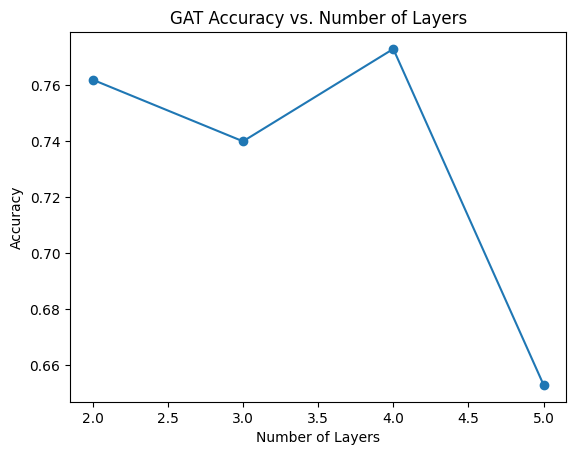

In [33]:
torch_geometric.seed_everything(50)
results = train_and_evaluate_gat(dataset, device, layer_counts=[2, 3, 4, 5])

Epoch 1, Loss: 1.9532
Epoch 2, Loss: 1.9460
Epoch 3, Loss: 1.9456
Epoch 4, Loss: 1.9445
Epoch 5, Loss: 1.9424
Epoch 6, Loss: 1.9388
Epoch 7, Loss: 1.9349
Epoch 8, Loss: 1.9299
Epoch 9, Loss: 1.9291
Epoch 10, Loss: 1.9255
Epoch 11, Loss: 1.9190
Epoch 12, Loss: 1.9213
Epoch 13, Loss: 1.9210
Epoch 14, Loss: 1.9146
Epoch 15, Loss: 1.9072
Epoch 16, Loss: 1.8980
Epoch 17, Loss: 1.9029
Epoch 18, Loss: 1.8857
Epoch 19, Loss: 1.8847
Epoch 20, Loss: 1.8702
Epoch 21, Loss: 1.8725
Epoch 22, Loss: 1.8661
Epoch 23, Loss: 1.8578
Epoch 24, Loss: 1.8434
Epoch 25, Loss: 1.8432
Epoch 26, Loss: 1.8342
Epoch 27, Loss: 1.8236
Epoch 28, Loss: 1.7919
Epoch 29, Loss: 1.8051
Epoch 30, Loss: 1.7709
Epoch 31, Loss: 1.7632
Epoch 32, Loss: 1.7597
Epoch 33, Loss: 1.7453
Epoch 34, Loss: 1.7196
Epoch 35, Loss: 1.7483
Epoch 36, Loss: 1.7121
Epoch 37, Loss: 1.7347
Epoch 38, Loss: 1.6899
Epoch 39, Loss: 1.6600
Epoch 40, Loss: 1.6210
Epoch 41, Loss: 1.6061
Epoch 42, Loss: 1.6227
Epoch 43, Loss: 1.5953
Epoch 44, Loss: 1.60

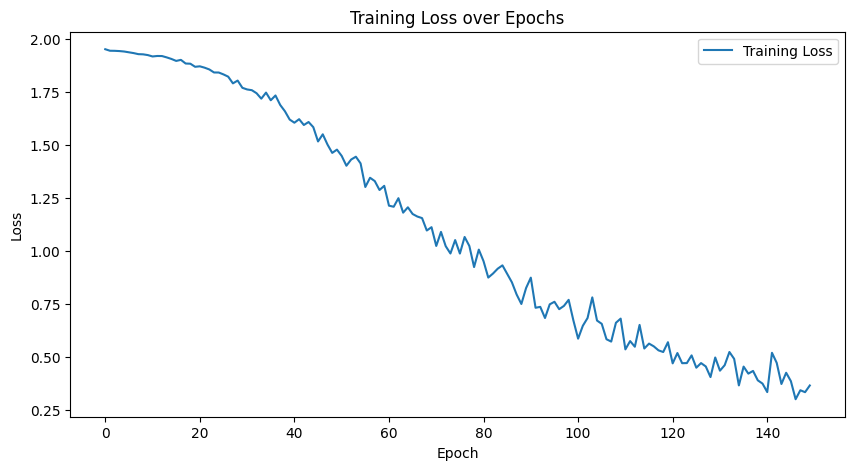

In [55]:
torch_geometric.seed_everything(50)
model = EnhancedGAT(dataset.num_node_features, dataset.num_classes)
train_acc, test_acc, train_losses = train_and_evaluate_node_classification(model, data, device, torch.nn.CrossEntropyLoss(), 150, lr=0.001, weight_decay=5e-4)  
plot_losses(train_losses)

Epoch 1, Loss: 862.0986
Epoch 2, Loss: 856.6836
Epoch 3, Loss: 852.2565
Epoch 4, Loss: 848.7630
Epoch 5, Loss: 845.5346
Epoch 6, Loss: 842.8455
Epoch 7, Loss: 840.3283
Epoch 8, Loss: 837.8819
Epoch 9, Loss: 835.3852
Epoch 10, Loss: 832.0213
Epoch 11, Loss: 829.2675
Epoch 12, Loss: 827.1333
Epoch 13, Loss: 825.0734
Epoch 14, Loss: 823.7732
Epoch 15, Loss: 822.4927
Epoch 16, Loss: 821.4300
Epoch 17, Loss: 820.5794
Epoch 18, Loss: 819.8946
Epoch 19, Loss: 819.2652
Epoch 20, Loss: 818.7758
Epoch 21, Loss: 818.2729
Epoch 22, Loss: 817.8556
Epoch 23, Loss: 817.6407
Epoch 24, Loss: 817.1601
Epoch 25, Loss: 816.7744
Epoch 26, Loss: 816.5676
Epoch 27, Loss: 816.8925
Epoch 28, Loss: 815.9721
Epoch 29, Loss: 815.7799
Epoch 30, Loss: 815.6096
Epoch 31, Loss: 815.3743
Epoch 32, Loss: 815.0830
Epoch 33, Loss: 814.9691
Epoch 34, Loss: 814.5810
Epoch 35, Loss: 814.4111
Epoch 36, Loss: 814.3528
Epoch 37, Loss: 814.4370
Epoch 38, Loss: 814.0028
Epoch 39, Loss: 813.7786
Epoch 40, Loss: 813.6228
Epoch 41,

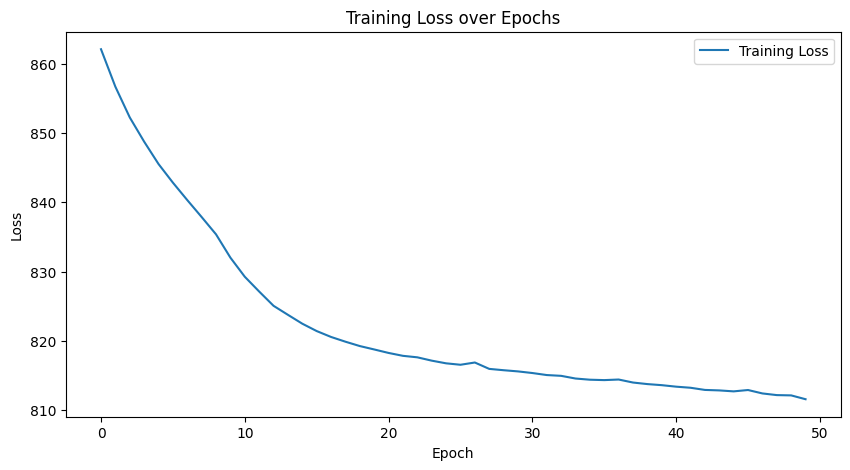

Epoch 1, Loss: 556.6144
Epoch 2, Loss: 555.3180
Epoch 3, Loss: 555.1926
Epoch 4, Loss: 555.2959
Epoch 5, Loss: 555.1118
Epoch 6, Loss: 555.1390
Epoch 7, Loss: 555.0387
Epoch 8, Loss: 554.9993
Epoch 9, Loss: 555.0032
Epoch 10, Loss: 554.9345
Epoch 11, Loss: 554.9120
Epoch 12, Loss: 555.0372
Epoch 13, Loss: 554.9242
Epoch 14, Loss: 554.9174
Epoch 15, Loss: 554.9126
Epoch 16, Loss: 554.9367
Epoch 17, Loss: 554.9219
Epoch 18, Loss: 554.9027
Epoch 19, Loss: 554.9116
Epoch 20, Loss: 555.0732
Epoch 21, Loss: 554.9355
Epoch 22, Loss: 555.1225
Epoch 23, Loss: 554.9939
Epoch 24, Loss: 555.0306
Epoch 25, Loss: 555.0028
Epoch 26, Loss: 554.9845
Epoch 27, Loss: 555.0164
Epoch 28, Loss: 555.1270
Epoch 29, Loss: 555.0043
Epoch 30, Loss: 554.9835
Epoch 31, Loss: 554.9699
Epoch 32, Loss: 554.9580
Epoch 33, Loss: 555.3359
Epoch 34, Loss: 555.0099
Epoch 35, Loss: 555.0001
Epoch 36, Loss: 555.0160
Epoch 37, Loss: 554.9787
Epoch 38, Loss: 555.0190
Epoch 39, Loss: 555.3168
Epoch 40, Loss: 555.0820
Epoch 41,

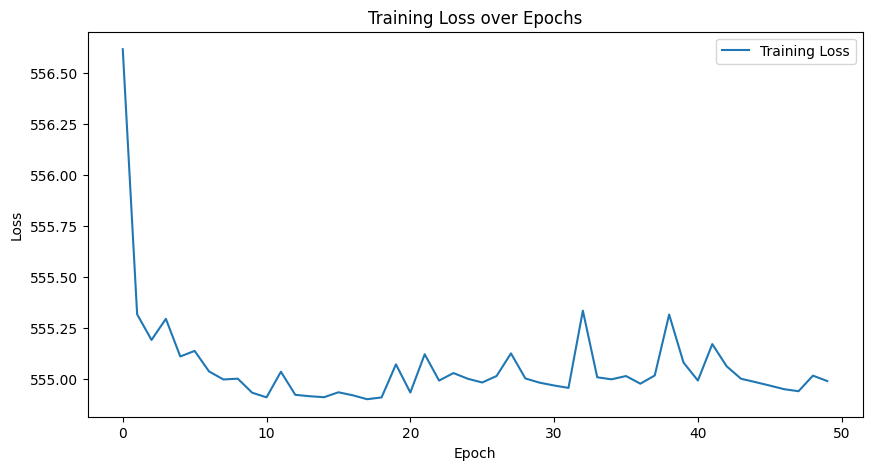

In [53]:
torch_geometric.seed_everything(50)
model_enz = GATGraphClassifier(num_features=enzymes_dataset.num_node_features, num_classes=enzymes_dataset.num_classes)
train_acc, test_acc, train_losses = train_and_evaluate(model_enz, train_data_enz, test_data_enz, criterion = torch.nn.CrossEntropyLoss(), epochs=50, lr=0.001, weight_decay=5e-4)
plot_losses(train_losses)

model_imdb = GATGraphClassifier(num_features=1, num_classes=2)  
train_acc, test_acc, train_losses = train_and_evaluate(model_imdb, train_data_imdb, test_data_imdb, criterion = torch.nn.CrossEntropyLoss(), epochs=50, lr=0.001, weight_decay=5e-4)
plot_losses(train_losses)

Epoch 1, Loss: 862.0986
Epoch 2, Loss: 856.6836
Epoch 3, Loss: 852.2565
Epoch 4, Loss: 848.7630
Epoch 5, Loss: 845.5346
Epoch 6, Loss: 842.8455
Epoch 7, Loss: 840.3283
Epoch 8, Loss: 837.8819
Epoch 9, Loss: 835.3852
Epoch 10, Loss: 832.0213
Epoch 11, Loss: 829.2675
Epoch 12, Loss: 827.1333
Epoch 13, Loss: 825.0734
Epoch 14, Loss: 823.7732
Epoch 15, Loss: 822.4927
Epoch 16, Loss: 821.4300
Epoch 17, Loss: 820.5794
Epoch 18, Loss: 819.8946
Epoch 19, Loss: 819.2652
Epoch 20, Loss: 818.7758
Epoch 21, Loss: 818.2729
Epoch 22, Loss: 817.8556
Epoch 23, Loss: 817.6407
Epoch 24, Loss: 817.1601
Epoch 25, Loss: 816.7744
Epoch 26, Loss: 816.5676
Epoch 27, Loss: 816.8925
Epoch 28, Loss: 815.9721
Epoch 29, Loss: 815.7799
Epoch 30, Loss: 815.6096
Epoch 31, Loss: 815.3743
Epoch 32, Loss: 815.0830
Epoch 33, Loss: 814.9691
Epoch 34, Loss: 814.5810
Epoch 35, Loss: 814.4111
Epoch 36, Loss: 814.3528
Epoch 37, Loss: 814.4370
Epoch 38, Loss: 814.0028
Epoch 39, Loss: 813.7786
Epoch 40, Loss: 813.6228
Epoch 41,

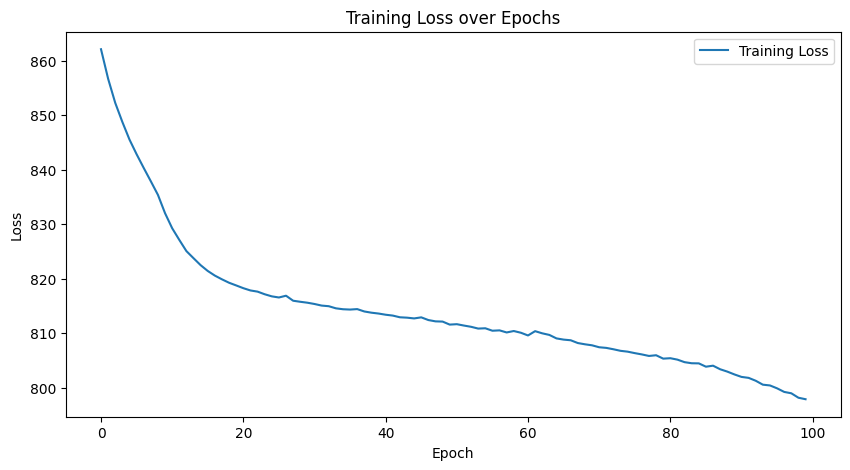

Epoch 1, Loss: 556.6144
Epoch 2, Loss: 555.3180
Epoch 3, Loss: 555.1926
Epoch 4, Loss: 555.2959
Epoch 5, Loss: 555.1118
Epoch 6, Loss: 555.1390
Epoch 7, Loss: 555.0387
Epoch 8, Loss: 554.9993
Epoch 9, Loss: 555.0032
Epoch 10, Loss: 554.9345
Epoch 11, Loss: 554.9120
Epoch 12, Loss: 555.0372
Epoch 13, Loss: 554.9242
Epoch 14, Loss: 554.9174
Epoch 15, Loss: 554.9126
Epoch 16, Loss: 554.9367
Epoch 17, Loss: 554.9219
Epoch 18, Loss: 554.9027
Epoch 19, Loss: 554.9116
Epoch 20, Loss: 555.0732
Epoch 21, Loss: 554.9355
Epoch 22, Loss: 555.1225
Epoch 23, Loss: 554.9939
Epoch 24, Loss: 555.0306
Epoch 25, Loss: 555.0028
Epoch 26, Loss: 554.9845
Epoch 27, Loss: 555.0164
Epoch 28, Loss: 555.1270
Epoch 29, Loss: 555.0043
Epoch 30, Loss: 554.9835
Epoch 31, Loss: 554.9699
Epoch 32, Loss: 554.9580
Epoch 33, Loss: 555.3359
Epoch 34, Loss: 555.0099
Epoch 35, Loss: 555.0001
Epoch 36, Loss: 555.0160
Epoch 37, Loss: 554.9787
Epoch 38, Loss: 555.0190
Epoch 39, Loss: 555.3168
Epoch 40, Loss: 555.0820
Epoch 41,

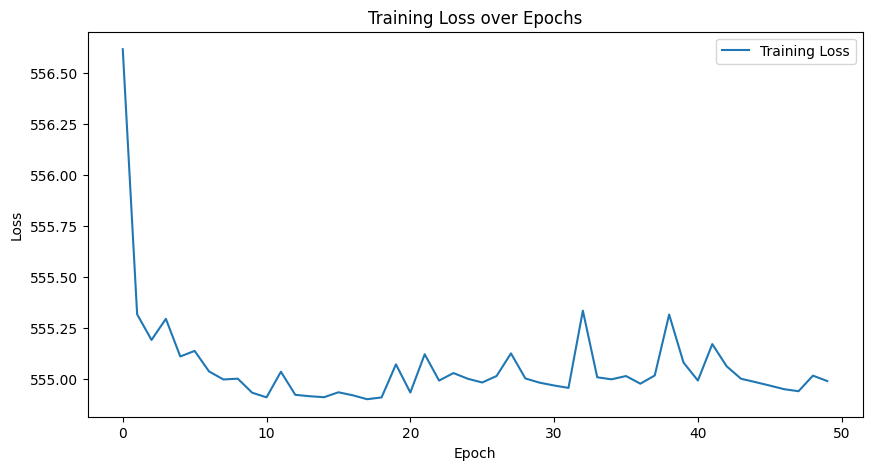

In [54]:
torch_geometric.seed_everything(50)
model_enz = GATGraphClassifier(num_features=enzymes_dataset.num_node_features, num_classes=enzymes_dataset.num_classes)
train_acc, test_acc, train_losses = train_and_evaluate(model_enz, train_data_enz, test_data_enz, criterion = torch.nn.CrossEntropyLoss(), epochs=100, lr=0.001, weight_decay=5e-4)
plot_losses(train_losses)

model_imdb = GATGraphClassifier(num_features=1, num_classes=2)  
train_acc, test_acc, train_losses = train_and_evaluate(model_imdb, train_data_imdb, test_data_imdb, criterion = torch.nn.CrossEntropyLoss(), epochs=50, lr=0.001, weight_decay=5e-4)
plot_losses(train_losses)